<a href="https://colab.research.google.com/github/SoniaVG/Time-series/blob/main/series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRONOSTICO DE SERIES TEMPORALES

Obtenido de:

https://cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html


# Predicciones multi-step
En series temporales, el objetivo es poder predecir los siguientes valores de la serie: $x_{t+1},x_{t+2},\ldots$. A cada paso de predicción se le conoce como *step*. Actualente existen varias estrategias que permiten generar este tipo de predicciones múltiples.


1. # Recursive multi-step forecasting
 Para predecir el momento  $x_n$, se necesita el valor de  $x_{n-1}$
 , y  $x_{n-1}$ se desconoce, es necessario seguir un proceso recursivo en el que cada nueva predicción, hace uso de predicciones anteriores. A este proceso se le conoce como **recursive forecasting** o **recursive multi-step forecasting** y pueden generarse fácilmente con las clases **ForecasterAutoreg** y **ForecasterAutoregCustom** de la librería **skforecast**.

2.  # Direct multi-step forecasting

 El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, entonces se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras, hay un alto coste computacional  y existe complejidada al generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase **ForecasterAutoregDirect** de la librería **skforecast**.



In [2]:
from IPython.display import clear_output
clear_output()

In [3]:
!pip install skforecast
clear_output()

In [4]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

# **DATOS**

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual.

In [5]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

In [6]:
print(datos.head(5))
# Identificamos el número de missing values en cada columna
print(datos.isnull().sum())


        fecha         y    exog_1    exog_2
0  1992-04-01  0.379808  0.958792  1.166029
1  1992-05-01  0.361801  0.951993  1.117859
2  1992-06-01  0.410534  0.952955  1.067942
3  1992-07-01  0.483389  0.958078  1.097376
4  1992-08-01  0.475463  0.956370  1.122199
fecha     0
y         0
exog_1    0
exog_2    0
dtype: int64


In [7]:
# PROCESAMIENTO DE LOS DATOS
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')

# Poner las fechas como los indices
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})

# Además, dado que los datos son mensuales, se indica la frecuencia (Monthly Started 'MS'). Aunque en este caso no es necesario
datos = datos.asfreq('MS')

# Ordenar las fechas
datos = datos.sort_index()
datos.head(10)

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
1992-09-01,0.534761,0.959610,1.153190
1992-10-01,0.568606,0.956205,1.194551
1992-11-01,0.595223,0.949715,1.231489
1992-12-01,0.771258,0.993219,1.289062


<Axes: xlabel='fecha'>

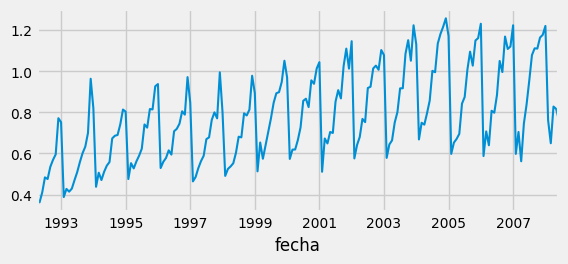

In [8]:
fig, ax = plt.subplots(figsize=(6, 2.5))
datos.y.plot(ax=ax, label='Datos')


**Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.**

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


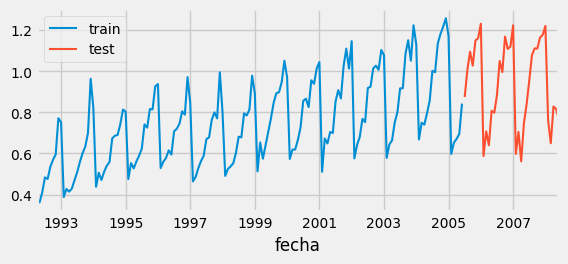

In [9]:

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

# **Forecasting autorregresivo recursivo**


In [10]:
# Crear y entrenar forecaster
#
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6 # Retrasos utilizados como predictores
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-19 19:34:40 
Last fit date: 2023-10-19 19:34:40 
Skforecast version: 0.10.1 
Python version: 

In [11]:
# Predicciones de los últimos 36 meses
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

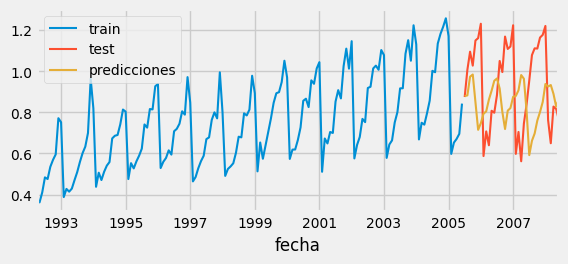

In [12]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [13]:
# Medida del error: Error cuadrático medio
# Error test: 1/n sum_i (y_i-y)^2
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")


Error de test (mse): 0.07326833976120374


# **Podemos mejorar el modelo**
**Ajuste de hiperparámetros (tuning)**

In [14]:
# Grid search
#=========================================================
# Entrenamos otros modelos para mejorar el modelo anterior

steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Marcador de posición, el valor se sobrescribirá
                )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        return_best = True
                  )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 8 observations.

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per f

In [15]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.021993,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.022114,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.022224,10,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.022530,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.023400,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.064775,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.066307,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.067151,5,100


In [16]:
# regresa las características del mejor modelo, por el parametro: return_best = True
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-19 19:42:08 
Las

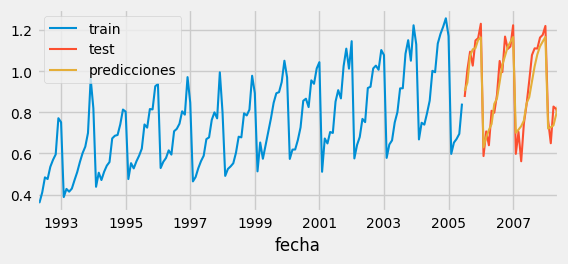

In [17]:
# Ver resultados con el mejor modelo
forecaster.fit(y=datos_train['y'])
predicciones = forecaster.predict(steps=steps)
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Evaluar el error en el conjunto de prueba/TEST
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.004392699665157793


# **Estrategias de Backtesting**

El proceso de backtesting es otra forma que nos permite evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. Así, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo.


1.   **Backtesting con reentrenamiento:**

El modelo se entrena una vez antes de realizar las predicciones. Así, para la sisuiente predicción, se amplia el conjunto de entrenamiento agregando estas predicciones al nuevo  conjunto de entrenamiento, ie.
 ie. se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de cross-validation en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.

2.   **Backtesting con reentrenamiento y tamaño de entrenamiento constante:**

En este caso, el tamaño del conjunto de entrenamiento no se incrementa sino que se fija una ventana de tiempo que se desplaza. Esta estrategia se conoce también como time series cross-validation o walk-forward validation

3.   **Backtesting con reentrenamiento cada n periodos (intermitente)**

El modelo se reentrena de forma intermitente cada  n
  periodos de predicción. Esta estrategia suele lograr un buen equilibrio entre el coste computacional del reentrenamiento y evitar la degradación del modelo.

4.  **Backtesting sin reentrenamiento**

El modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. Aunque esta estrategia suele ser mucho más rápida, la desventaja es que no se incorpora la última información disponible al entrenamiento, por lo que puede perder capacidad predictiva con el tiempo.



In [24]:
# Cantidad de meses disponibles en la base de datos
print(datos.shape)
print(len(datos)-108)

(195, 3)
87


In [23]:
# Backtesting con reentrenamiento
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años = 36*3 = 108 meses

# Se empieza entonces entrenando con 87 observaciones
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

Error de backtest: 0.010578977232387663


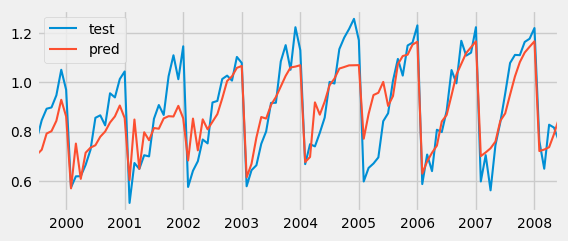

In [25]:
fig, ax = plt.subplots(figsize=(6, 2.5))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();